# Word Counts: Periodic Invoices - Fraud Accounts

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats
get_ipython().magic(u'config IPCompleter.greedy=True')

sns.set(color_codes=True)

# Connecting with the AWS Redshift database

In [188]:
from contextlib import closing


import psycopg2
import pandas as pd
import simplejson

DEFAULT_DB = 'data_depot'
DEFAULT_HOST = 'freshbooks-data.c8exzn6geij3.us-east-1.redshift.amazonaws.com'
DEFAULT_PORT = 5439


class PsycopgConnector:
    '''
    A database connector that uses Psycopg to connect to Redshift.

    How to play:

        psy_conn = PsycopgConnector(username, password)
        df = psy_conn.run_query(sql=sql, return_data=True)

    NOTE: This class commits queries to redshift if return_data=False.
    This means INSERT, DROP, TRUNCATE, etc. all work against the DB.
    '''

    def __init__(
        self,
        username=None,
        password=None,
        db=DEFAULT_DB,
        host=DEFAULT_HOST,
        port=DEFAULT_PORT,
    ):

        self.db = DEFAULT_DB
        self.host = DEFAULT_HOST
        self.port = DEFAULT_PORT

        self.username = username
        self.password = password

    def _get_connection(self):

        self.conn = psycopg2.connect(
            dbname=self.db,
            user=self.username,
            password=self.password,
            host=self.host,
            port=self.port
        )

        return self.conn

    def run_query(self, sql, return_data=False):

        with closing(self._get_connection()) as conn:
            with conn, conn.cursor() as cur:
                if return_data:
                    return pd.read_sql(sql=sql, con=conn)
                else:
                    cur.execute(sql)

In [189]:
# Read the Redshift's credentials file 
with open("redshift_creds.json.nogit") as fh:
    creds = simplejson.loads(fh.read())
    
username = creds.get("user_name")
password = creds.get("password")

pig = PsycopgConnector(username, password)

In [190]:
username = creds.get("user_name")
password = creds.get("password")

In [36]:
# Test the connection
query = "SELECT * FROM report_systems LIMIT 10"

In [37]:
df = pig.run_query(query, return_data=True)

In [38]:
df.head(2)

,systemid,business_id,admin_identity_id,subdomain,is_freshbooks_account_active,is_modern,most_recent_migrated_to_smux_at,is_contractor,currency_code,timezone,...,staff_count,staff_deleted_count,contractor_count,contractor_deleted_count,user_contact_count,enabled_gateway_count,google_sso_first_linked_date,google_sso_most_recent_linked_date,google_sso_first_removal_date,google_sso_most_recent_removal_date
0,273,None,None,https://WebbuildersNorthwest.freshbooks.com,1,0,None,0,USD,US/Eastern,...,0,0,0,0,0,1,None,None,None,None
1,2420,None,None,https://ga.freshbooks.com,1,0,None,0,USD,Canada/Atlantic,...,0,1,0,0,0,1,None,None,None,None


## Connect with the Redshift Database

In [22]:
# import sqlalchemy
# import psycopg2
# import simplejson
# %load_ext sql
# %config SqlMagic.displaylimit = 5

# import sys
# reload(sys)
# sys.setdefaultencoding('utf8')

In [23]:
# # Read the Redshift's credentials file 
# with open("redshift_creds.json.nogit") as fh:
#     creds = simplejson.loads(fh.read())

# # Connect to the Redshift
# connect_to_db = 'postgresql+psycopg2://' + \
#                 creds['user_name'] + ':' + creds['password'] + '@' + \
#                 creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];
# %sql $connect_to_db

## Functions

In [24]:
# Word count fuction
import re
def words_count (strg):
    
    #print(strg)
    
    if strg == '' or pd.isnull(strg):
        no_of_words = 0
        #print('NaN')
    else:
        strg_words_list = re.findall(r"[\w']+", strg)
        no_of_words = len(strg_words_list)

        
        #print(strg_words_list)
    
    return no_of_words 
    

# 1. Periodic Invoices data

## 1.1 Data Import
### 1.1.1 Words count for 7 days periodic invoice data

In [148]:
# SQL for impoorting fraud invoices created within 7 days after signup_date
sql_invoices_7days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 7) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_7days_fraud_accounts = pig.run_query(sql_invoices_7days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_7days_fraud_accounts['avg_wc_description_day_7'] = df_invoices_7days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_7days_fraud_accounts['avg_wc_notes_day_7'] = df_invoices_7days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_7days_fraud_accounts['avg_wc_terms_day_7'] = df_invoices_7days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_7days_fraud_accounts['avg_wc_address_day_7'] = df_invoices_7days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_7days_fraud_accounts_fil = df_invoices_7days_fraud_accounts.filter(['systemid', 
                                                                                'invoiceid', 
                                                                                'signup_date', 
                                                                                'is_freshbooks_account_active',
                                                                                'is_sales_managed',
                                                                                'create_date', 
                                                                                'created_at',
                                                                                'days_to_invoice_creation', 
                                                                                'avg_wc_description_day_7', 
                                                                                'avg_wc_notes_day_7', 
                                                                                'avg_wc_terms_day_7',
                                                                                'avg_wc_address_day_7'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_7days_fraud_accounts_total = df_invoices_7days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_7days_fraud_accounts_final = df_word_count_7days_fraud_accounts_total.filter(['systemid',
                                                                            'is_freshbooks_account_active',
                                                                            'is_sales_managed',
                                                                            'avg_wc_description_day_7', 
                                                                            'avg_wc_notes_day_7', 
                                                                            'avg_wc_terms_day_7',
                                                                            'avg_wc_address_day_7'])

In [149]:
df_word_count_7days_fraud_accounts_final.shape

(403, 6)

In [150]:
list(df_word_count_7days_fraud_accounts_final)

['is_freshbooks_account_active',
 'is_sales_managed',
 'avg_wc_description_day_7',
 'avg_wc_notes_day_7',
 'avg_wc_terms_day_7',
 'avg_wc_address_day_7']

### 1.1.2 Words counts for 14 days periodic invoice data

In [40]:
# SQL for impoorting fraud invoices created within 14 days after signup_date
sql_invoices_14days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 14) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_14days_fraud_accounts = \
    pig.run_query(sql_invoices_14days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_14days_fraud_accounts['avg_wc_description_day_14'] = df_invoices_14days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_14days_fraud_accounts['avg_wc_notes_day_14'] = df_invoices_14days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_14days_fraud_accounts['avg_wc_terms_day_14'] = df_invoices_14days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_14days_fraud_accounts['avg_wc_address_day_14'] = df_invoices_14days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_14days_fraud_accounts_fil = df_invoices_14days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_14', 
                                                                            'avg_wc_notes_day_14', 
                                                                            'avg_wc_terms_day_14',
                                                                            'avg_wc_address_day_14'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_14days_fraud_accounts_total = df_invoices_14days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_14days_fraud_accounts_final = df_word_count_14days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_14', 
                                                                            'avg_wc_notes_day_14', 
                                                                            'avg_wc_terms_day_14',
                                                                            'avg_wc_address_day_14'])


In [51]:
df_word_count_14days_fraud_accounts_final.shape

(411, 4)

### 1.1.3 Word count for 21 days periodic invoices data

In [43]:
# SQL for impoorting fraud invoices created within 21 days after signup_date
sql_invoices_21days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 21) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_21days_fraud_accounts = pig.run_query(sql_invoices_21days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_21days_fraud_accounts['avg_wc_description_day_21'] = df_invoices_21days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_21days_fraud_accounts['avg_wc_notes_day_21'] = df_invoices_21days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_21days_fraud_accounts['avg_wc_terms_day_21'] = df_invoices_21days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_21days_fraud_accounts['avg_wc_address_day_21'] = df_invoices_21days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_21days_fraud_accounts_fil = df_invoices_21days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_21', 
                                                                            'avg_wc_notes_day_21', 
                                                                            'avg_wc_terms_day_21',
                                                                            'avg_wc_address_day_21'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_21days_fraud_accounts_total = df_invoices_21days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_21days_fraud_accounts_final = df_word_count_21days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_21', 
                                                                            'avg_wc_notes_day_21', 
                                                                            'avg_wc_terms_day_21',
                                                                            'avg_wc_address_day_21'])


In [50]:
df_word_count_21days_fraud_accounts_final.shape

(417, 4)

### 1.1.4 Words counts for 28 days periodic invoicd data

In [46]:
# SQL for impoorting fraud invoices created within 28 days after signup_date
sql_invoices_28days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 21) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_28days_fraud_accounts = pig.run_query(sql_invoices_28days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_28days_fraud_accounts['avg_wc_description_day_28'] = df_invoices_28days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_28days_fraud_accounts['avg_wc_notes_day_28'] = df_invoices_28days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_28days_fraud_accounts['avg_wc_terms_day_28'] = df_invoices_28days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_28days_fraud_accounts['avg_wc_address_day_28'] = df_invoices_28days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_28days_fraud_accounts_fil = df_invoices_28days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_28', 
                                                                            'avg_wc_notes_day_28', 
                                                                            'avg_wc_terms_day_28',
                                                                            'avg_wc_address_day_28'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_28days_fraud_accounts_total = df_invoices_28days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_28days_fraud_accounts_final = df_word_count_28days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_28', 
                                                                            'avg_wc_notes_day_28', 
                                                                            'avg_wc_terms_day_28',
                                                                            'avg_wc_address_day_28'])


In [55]:
df_word_count_28days_fraud_accounts_final.shape

(417, 4)

### 1.1.5 Words counts for 35 days periodic invoice data

In [56]:
# SQL for impoorting fraud invoices created within 35 days after signup_date
sql_invoices_35days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 35) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_35days_fraud_accounts = pig.run_query(sql_invoices_35days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_35days_fraud_accounts['avg_wc_description_day_35'] = df_invoices_35days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_35days_fraud_accounts['avg_wc_notes_day_35'] = df_invoices_35days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_35days_fraud_accounts['avg_wc_terms_day_35'] = df_invoices_35days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_35days_fraud_accounts['avg_wc_address_day_35'] = df_invoices_35days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_35days_fraud_accounts_fil = df_invoices_35days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_35', 
                                                                            'avg_wc_notes_day_35', 
                                                                            'avg_wc_terms_day_35',
                                                                            'avg_wc_address_day_35'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_35days_fraud_accounts_total = df_invoices_35days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_35days_fraud_accounts_final = df_word_count_35days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_35', 
                                                                            'avg_wc_notes_day_35', 
                                                                            'avg_wc_terms_day_35',
                                                                            'avg_wc_address_day_35'])


In [57]:
df_word_count_35days_fraud_accounts_final.shape

(421, 4)

### 1.1.6 Words counts for 42 days periodic invoice data

In [64]:
# SQL for impoorting fraud invoices created within 42 days after signup_date
sql_invoices_42days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 42) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_42days_fraud_accounts = pig.run_query(sql_invoices_42days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_42days_fraud_accounts['avg_wc_description_day_42'] = df_invoices_42days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_42days_fraud_accounts['avg_wc_notes_day_42'] = df_invoices_42days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_42days_fraud_accounts['avg_wc_terms_day_42'] = df_invoices_42days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_42days_fraud_accounts['avg_wc_address_day_42'] = df_invoices_42days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_42days_fraud_accounts_fil = df_invoices_42days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_42', 
                                                                            'avg_wc_notes_day_42', 
                                                                            'avg_wc_terms_day_42',
                                                                            'avg_wc_address_day_42'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_42days_fraud_accounts_total = df_invoices_42days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_42days_fraud_accounts_final = df_word_count_42days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_42', 
                                                                            'avg_wc_notes_day_42', 
                                                                            'avg_wc_terms_day_42',
                                                                            'avg_wc_address_day_42'])


In [62]:
df_word_count_42days_fraud_accounts_final.shape

(403, 4)

### 1.1.7 Words counts for 49 days periodic invoice data

In [65]:
# SQL for impoorting fraud invoices created within 49 days after signup_date
sql_invoices_49days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 49) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_49days_fraud_accounts = pig.run_query(sql_invoices_49days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_49days_fraud_accounts['avg_wc_description_day_49'] = df_invoices_49days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_49days_fraud_accounts['avg_wc_notes_day_49'] = df_invoices_49days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_49days_fraud_accounts['avg_wc_terms_day_49'] = df_invoices_49days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_49days_fraud_accounts['avg_wc_address_day_49'] = df_invoices_49days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_49days_fraud_accounts_fil = df_invoices_49days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_49', 
                                                                            'avg_wc_notes_day_49', 
                                                                            'avg_wc_terms_day_49',
                                                                            'avg_wc_address_day_49'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_49days_fraud_accounts_total = df_invoices_49days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_49days_fraud_accounts_final = df_word_count_49days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_49', 
                                                                            'avg_wc_notes_day_49', 
                                                                            'avg_wc_terms_day_49',
                                                                            'avg_wc_address_day_49'])


In [67]:
df_word_count_49days_fraud_accounts_final.shape

(422, 4)

### 1.1.8 Words counts for 56 days periodic invoice data

In [68]:
# SQL for impoorting fraud invoices created within 56 days after signup_date
sql_invoices_56days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 56) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_56days_fraud_accounts = pig.run_query(sql_invoices_56days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_56days_fraud_accounts['avg_wc_description_day_56'] = df_invoices_56days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_56days_fraud_accounts['avg_wc_notes_day_56'] = df_invoices_56days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_56days_fraud_accounts['avg_wc_terms_day_56'] = df_invoices_56days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_56days_fraud_accounts['avg_wc_address_day_56'] = df_invoices_56days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_56days_fraud_accounts_fil = df_invoices_56days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_56', 
                                                                            'avg_wc_notes_day_56', 
                                                                            'avg_wc_terms_day_56',
                                                                            'avg_wc_address_day_56'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_56days_fraud_accounts_total = df_invoices_56days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_56days_fraud_accounts_final = df_word_count_56days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_56', 
                                                                            'avg_wc_notes_day_56', 
                                                                            'avg_wc_terms_day_56',
                                                                            'avg_wc_address_day_56'])


In [69]:
df_word_count_56days_fraud_accounts_final.shape

(422, 4)

### 1.1.9 Words counts for 63 days periodic invoice data

In [70]:
# SQL for impoorting fraudinvoices created within 63 days after signup_date
sql_invoices_63days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 63) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_63days_fraud_accounts = pig.run_query(sql_invoices_63days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_63days_fraud_accounts['avg_wc_description_day_63'] = df_invoices_63days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_63days_fraud_accounts['avg_wc_notes_day_63'] = df_invoices_63days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_63days_fraud_accounts['avg_wc_terms_day_63'] = df_invoices_63days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_63days_fraud_accounts['avg_wc_address_day_63'] = df_invoices_63days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_63days_fraud_accounts_fil = df_invoices_63days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_63', 
                                                                            'avg_wc_notes_day_63', 
                                                                            'avg_wc_terms_day_63',
                                                                            'avg_wc_address_day_63'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_63days_fraud_accounts_total = df_invoices_63days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_63days_fraud_accounts_final = df_word_count_63days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_63', 
                                                                            'avg_wc_notes_day_63', 
                                                                            'avg_wc_terms_day_63',
                                                                            'avg_wc_address_day_63'])


In [71]:
df_word_count_63days_fraud_accounts_final.shape

(424, 4)

### 1.1.10 Words counts for 70 days periodic invoice data

In [72]:
# SQL for impoorting all invoices created within 70 days after signup_date
sql_invoices_70days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 70) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_70days_fraud_accounts = pig.run_query(sql_invoices_70days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_70days_fraud_accounts['avg_wc_description_day_70'] = df_invoices_70days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_70days_fraud_accounts['avg_wc_notes_day_70'] = df_invoices_70days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_70days_fraud_accounts['avg_wc_terms_day_70'] = df_invoices_70days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_70days_fraud_accounts['avg_wc_address_day_70'] = df_invoices_70days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_70days_fraud_accounts_fil = df_invoices_70days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_70', 
                                                                            'avg_wc_notes_day_70', 
                                                                            'avg_wc_terms_day_70',
                                                                            'avg_wc_address_day_70'])  
                                                                                                                   
# Summing (grouping) fraud invoices for a 'systemid'
df_word_count_70days_fraud_accounts_total = df_invoices_70days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_70days_fraud_accounts_final = df_word_count_70days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_70', 
                                                                            'avg_wc_notes_day_70', 
                                                                            'avg_wc_terms_day_70',
                                                                            'avg_wc_address_day_70'])


In [73]:
df_word_count_70days_fraud_accounts_final.shape

(426, 4)

### 1.1.11 Word counts for 77 days periodic invoice data

In [74]:
# SQL for impoorting all invoices created within 77 days after signup_date
sql_invoices_77days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 77) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_77days_fraud_accounts = pig.run_query(sql_invoices_77days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_77days_fraud_accounts['avg_wc_description_day_77'] = df_invoices_77days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_77days_fraud_accounts['avg_wc_notes_day_77'] = df_invoices_77days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_77days_fraud_accounts['avg_wc_terms_day_77'] = df_invoices_77days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_77days_fraud_accounts['avg_wc_address_day_77'] = df_invoices_77days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_77days_fraud_accounts_fil = df_invoices_77days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_77', 
                                                                            'avg_wc_notes_day_77', 
                                                                            'avg_wc_terms_day_77',
                                                                            'avg_wc_address_day_77'])  
                                                                                                                   
# Summing (grouping) all invoices for a 'systemid'
df_word_count_77days_fraud_accounts_total = df_invoices_77days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_77days_fraud_accounts_final = df_word_count_77days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_77', 
                                                                            'avg_wc_notes_day_77', 
                                                                            'avg_wc_terms_day_77',
                                                                            'avg_wc_address_day_77'])


In [75]:
df_word_count_77days_fraud_accounts_final.shape

(426, 4)

### 1.1.12 Word counts for 84 day periodic invoice data

In [76]:
# SQL for impoorting all invoices created within 84 days after signup_date
sql_invoices_84days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 84) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_84days_fraud_accounts = pig.run_query(sql_invoices_84days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_84days_fraud_accounts['avg_wc_description_day_84'] = df_invoices_84days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_84days_fraud_accounts['avg_wc_notes_day_84'] = df_invoices_84days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_84days_fraud_accounts['avg_wc_terms_day_84'] = df_invoices_84days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_84days_fraud_accounts['avg_wc_address_day_84'] = df_invoices_84days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_84days_fraud_accounts_fil = df_invoices_84days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_84', 
                                                                            'avg_wc_notes_day_84', 
                                                                            'avg_wc_terms_day_84',
                                                                            'avg_wc_address_day_84'])  
                                                                                                                   
# Summing (grouping) all invoices for a 'systemid'
df_word_count_84days_fraud_accounts_total = df_invoices_84days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_84days_fraud_accounts_final = df_word_count_84days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_84', 
                                                                            'avg_wc_notes_day_84', 
                                                                            'avg_wc_terms_day_84',
                                                                            'avg_wc_address_day_84'])


In [77]:
df_word_count_84days_fraud_accounts_final.shape

(426, 4)

### 1.1.13 Words counts for 91 days periodic invoice data

In [78]:
# SQL for impoorting all invoices created within 91 days after signup_date
sql_invoices_91days_fraud_accounts = '''WITH invoices_in_a_period AS (
    SELECT systemid, signup_date,
           is_freshbooks_account_active,
           is_sales_managed
    FROM report_systems rs
    JOIN data_science.fraud_accounts_list USING (systemid)
), invoice_created_at AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           pic.signup_date,
           pic.is_sales_managed,
           pic.is_freshbooks_account_active,
           inv.create_date,
           inv.created_at,
           inv.description,
           inv.notes,
           inv.terms,
           inv.address,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM invoices_in_a_period AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
    WHERE ((days_to_invoice_creation BETWEEN 0 AND 91) OR days_to_invoice_creation IS NULL) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
)

SELECT *
FROM invoice_created_at;'''

# Import as dataframe from redshift
df_invoices_91days_fraud_accounts = pig.run_query(sql_invoices_91days_fraud_accounts, return_data=True)

# Words count in invoice's description, notes, terms, address
df_invoices_91days_fraud_accounts['avg_wc_description_day_91'] = df_invoices_91days_fraud_accounts.apply(lambda x: words_count(x['description']), axis=1)
df_invoices_91days_fraud_accounts['avg_wc_notes_day_91'] = df_invoices_91days_fraud_accounts.apply(lambda x: words_count(x['notes']), axis=1)
df_invoices_91days_fraud_accounts['avg_wc_terms_day_91'] = df_invoices_91days_fraud_accounts.apply(lambda x: words_count(x['terms']), axis=1)
df_invoices_91days_fraud_accounts['avg_wc_address_day_91'] = df_invoices_91days_fraud_accounts.apply(lambda x: words_count(x['address']), axis=1)

                                                                                                                   
# Filters the text columns from the dataframe
df_invoices_91days_fraud_accounts_fil = df_invoices_91days_fraud_accounts.filter(['systemid', 'invoiceid', 
                                                                            'signup_date', 
                                                                            'create_date', 
                                                                            'created_at',
                                                                            'days_to_invoice_creation', 
                                                                            'avg_wc_description_day_91', 
                                                                            'avg_wc_notes_day_91', 
                                                                            'avg_wc_terms_day_91',
                                                                            'avg_wc_address_day_91'])  
                                                                                                                   
# Summing (grouping) all invoices for a 'systemid'
df_word_count_91days_fraud_accounts_total = df_invoices_91days_fraud_accounts_fil.groupby('systemid').mean()  

# Final word count table
df_word_count_91days_fraud_accounts_final = df_word_count_91days_fraud_accounts_total.filter(['systemid',
                                                                            'avg_wc_description_day_91', 
                                                                            'avg_wc_notes_day_91', 
                                                                            'avg_wc_terms_day_91',
                                                                            'avg_wc_address_day_91'])


In [79]:
df_word_count_91days_fraud_accounts_final.shape

(427, 4)

## 1.2 Joining All Average Words Counts Periodic Tables 

In [151]:
# Joininig day 7 and day 14 th dataframes
df_avg_invoice_word_count = pd.merge(df_word_count_7days_fraud_accounts_final, df_word_count_14days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 21 
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_21days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 28
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_28days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 35
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_35days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 42
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_42days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 49
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_49days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 56
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_56days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 63
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_63days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 70
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_70days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 77
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_77days_fraud_accounts_final,
                                     on='systemid', how='left')
# left join day 84
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_84days_fraud_accounts_final,
                                     on='systemid', how='left')

# left join day 91
df_avg_invoice_word_count = pd.merge(df_avg_invoice_word_count, df_word_count_91days_fraud_accounts_final,
                                     on='systemid', how='left')

In [152]:
df_avg_invoice_word_count.tail()

,is_freshbooks_account_active,is_sales_managed,avg_wc_description_day_7,avg_wc_notes_day_7,avg_wc_terms_day_7,avg_wc_address_day_7,avg_wc_description_day_14,avg_wc_notes_day_14,avg_wc_terms_day_14,avg_wc_address_day_14,...,avg_wc_terms_day_77,avg_wc_address_day_77,avg_wc_description_day_84,avg_wc_notes_day_84,avg_wc_terms_day_84,avg_wc_address_day_84,avg_wc_description_day_91,avg_wc_notes_day_91,avg_wc_terms_day_91,avg_wc_address_day_91
systemid,,,,,,,,,,,,,,,,,,,,,
4209018,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4219188,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4238602,0.0,0.0,5.5,71.750000,43.5,0.0,6.111111,67.777778,44.0,0.0,...,44.434783,0.0,7.347826,65.956522,44.434783,0.0,7.347826,65.956522,44.434783,0.0
4296696,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4316674,0.0,0.0,0.0,9.666667,4.0,0.0,0.000000,9.666667,4.0,0.0,...,4.000000,0.0,0.000000,9.666667,4.000000,0.0,0.000000,9.666667,4.000000,0.0


In [153]:
list(df_avg_invoice_word_count)

['is_freshbooks_account_active',
 'is_sales_managed',
 'avg_wc_description_day_7',
 'avg_wc_notes_day_7',
 'avg_wc_terms_day_7',
 'avg_wc_address_day_7',
 'avg_wc_description_day_14',
 'avg_wc_notes_day_14',
 'avg_wc_terms_day_14',
 'avg_wc_address_day_14',
 'avg_wc_description_day_21',
 'avg_wc_notes_day_21',
 'avg_wc_terms_day_21',
 'avg_wc_address_day_21',
 'avg_wc_description_day_28',
 'avg_wc_notes_day_28',
 'avg_wc_terms_day_28',
 'avg_wc_address_day_28',
 'avg_wc_description_day_35',
 'avg_wc_notes_day_35',
 'avg_wc_terms_day_35',
 'avg_wc_address_day_35',
 'avg_wc_description_day_42',
 'avg_wc_notes_day_42',
 'avg_wc_terms_day_42',
 'avg_wc_address_day_42',
 'avg_wc_description_day_49',
 'avg_wc_notes_day_49',
 'avg_wc_terms_day_49',
 'avg_wc_address_day_49',
 'avg_wc_description_day_56',
 'avg_wc_notes_day_56',
 'avg_wc_terms_day_56',
 'avg_wc_address_day_56',
 'avg_wc_description_day_63',
 'avg_wc_notes_day_63',
 'avg_wc_terms_day_63',
 'avg_wc_address_day_63',
 'avg_wc_descr

# 2. Periodic Report Systems, Invoice and Client Counts 

### 2.1 Import periodic invoice counts and client counts 

In [161]:
# SQL query 
sql_rs_invoices_clients_activities_fraud_accounts = '''WITH periodic_report_system_activities AS (
    SELECT systemid, signup_date, is_freshbooks_account_active, is_new_trial_from_accountant_invite,
           freshbooks_account_status, is_paying, base_subscription_amount_first_upgrade,
           subscription_package_name, upgrade_ever, signup_ip_address
    FROM report_systems rs
    WHERE systemid IN (
        SELECT systemid FROM data_science.fraud_accounts_list
        ) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
), invoice_create_date AS (
    SELECT
           pic.systemid,
           inv.invoiceid,
           inv.create_date,
           inv.created_at,
           DATEDIFF(days, pic.signup_date, inv.created_at) AS days_to_invoice_creation
    FROM periodic_report_system_activities AS pic
    LEFT JOIN coalesced_live_shards.invoice_stable as inv USING (systemid)
), invoice_grouping AS (
    SELECT
           systemid,
           COUNT(invoiceid) as invoice_count,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 7 THEN 1 ELSE 0 END) AS invoice_count_day_7,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 14 THEN 1 ELSE 0 END) AS invoice_count_day_14,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 21 THEN 1 ELSE 0 END) AS invoice_count_day_21,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 28 THEN 1 ELSE 0 END) AS invoice_count_day_28,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 35 THEN 1 ELSE 0 END) AS invoice_count_day_35,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 42 THEN 1 ELSE 0 END) AS invoice_count_day_42,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 49 THEN 1 ELSE 0 END) AS invoice_count_day_49,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 56 THEN 1 ELSE 0 END) AS invoice_count_day_56,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 63 THEN 1 ELSE 0 END) AS invoice_count_day_63,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 70 THEN 1 ELSE 0 END) AS invoice_count_day_70,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 77 THEN 1 ELSE 0 END) AS invoice_count_day_77,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 84 THEN 1 ELSE 0 END) AS invoice_count_day_84,
           SUM(CASE WHEN days_to_invoice_creation BETWEEN 0 AND 91 THEN 1 ELSE 0 END) AS invoice_count_day_91
    FROM invoice_create_date
    GROUP BY systemid
), client_crate_date AS (
     SELECT
            pic.systemid,
            usr.userid,
            usr.signup_date,
            DATEDIFF(days, pic.signup_date, usr.signup_date) AS days_to_client_creation
    FROM periodic_report_system_activities  AS pic
    LEFT JOIN coalesced_live_shards."user" as usr USING (systemid)
), client_grouping AS (
    SELECT
           systemid,
           count(userid) AS client_count,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 7 THEN 1 ELSE 0 END) AS client_count_day_7,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 14 THEN 1 ELSE 0 END) AS client_count_day_14,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 21 THEN 1 ELSE 0 END) AS client_count_day_21,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 28 THEN 1 ELSE 0 END) AS client_count_day_28,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 35 THEN 1 ELSE 0 END) AS client_count_day_35,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 42 THEN 1 ELSE 0 END) AS client_count_day_42,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 49 THEN 1 ELSE 0 END) AS client_count_day_49,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 56 THEN 1 ELSE 0 END) AS client_count_day_56,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 63 THEN 1 ELSE 0 END) AS client_count_day_63,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 70 THEN 1 ELSE 0 END) AS client_count_day_70,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 77 THEN 1 ELSE 0 END) AS client_count_day_77,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 84 THEN 1 ELSE 0 END) AS client_count_day_84,
           SUM(CASE WHEN days_to_client_creation BETWEEN 0 AND 91 THEN 1 ELSE 0 END) AS client_count_day_91
    FROM  client_crate_date
    GROUP BY systemid
)

SELECT
       systemid, signup_date,
       is_new_trial_from_accountant_invite,
       freshbooks_account_status, is_paying, base_subscription_amount_first_upgrade,
       subscription_package_name, upgrade_ever, signup_ip_address,
       inv_gr.invoice_count,
       inv_gr.invoice_count_day_7,
       inv_gr.invoice_count_day_14,
       inv_gr.invoice_count_day_21,
       inv_gr.invoice_count_day_28,
       inv_gr.invoice_count_day_35,
       inv_gr.invoice_count_day_42,
       inv_gr.invoice_count_day_49,
       inv_gr.invoice_count_day_56,
       inv_gr.invoice_count_day_63,
       inv_gr.invoice_count_day_70,
       inv_gr.invoice_count_day_77,
       inv_gr.invoice_count_day_84,
       inv_gr.invoice_count_day_91,
       cl_gr.client_count,
       cl_gr.client_count_day_7,
       cl_gr.client_count_day_14,
       cl_gr.client_count_day_21,
       cl_gr.client_count_day_28,
       cl_gr.client_count_day_35,
       cl_gr.client_count_day_42,
       cl_gr.client_count_day_49,
       cl_gr.client_count_day_56,
       cl_gr.client_count_day_63,
       cl_gr.client_count_day_70,
       cl_gr.client_count_day_77,
       cl_gr.client_count_day_84,
       cl_gr.client_count_day_91
FROM periodic_report_system_activities
LEFT JOIN invoice_grouping as inv_gr USING (systemid)
LEFT JOIN client_grouping AS cl_gr USING (systemid);
'''

# Import as dataframe from redshift
df_rs_invoices_clients_activities_fraud_accounts = pig.run_query(sql_rs_invoices_clients_activities_fraud_accounts, return_data=True)


In [162]:
df_rs_invoices_clients_activities_fraud_accounts.tail()

,systemid,signup_date,is_new_trial_from_accountant_invite,freshbooks_account_status,is_paying,base_subscription_amount_first_upgrade,subscription_package_name,upgrade_ever,signup_ip_address,invoice_count,...,client_count_day_28,client_count_day_35,client_count_day_42,client_count_day_49,client_count_day_56,client_count_day_63,client_count_day_70,client_count_day_77,client_count_day_84,client_count_day_91
429,3619825,2018-08-13,0,banned,0,15.00,,1,24.136.14.33,1,...,1,1,1,1,1,1,2,2,2,2
430,933680,2014-02-10,0,cancelled,0,323.46,Free,1,108.195.107.8,317,...,57,77,77,77,77,77,77,77,77,77
431,1017095,2014-05-01,0,cancelled,0,29.95,Free,1,50.13.43.252,154,...,57,61,67,68,70,71,71,74,76,77
432,1603650,2015-04-22,0,cancelled,0,19.95,Free,1,182.69.252.198,552,...,18,21,36,77,112,158,192,240,302,333
433,1225265,2014-09-30,0,cancelled,0,29.95,Free,1,50.13.43.252,956,...,44,53,73,98,126,146,161,185,209,229


In [88]:
df_rs_invoices_clients_activities_fraud_accounts.shape

(434, 38)

### 2.2 Joint average invoce word counts (description, notes etc.), and invoice & client counts 

In [163]:
# left join invoices' average periodic word counts (description, notes, terms, address) with the invices & client counts
df_periodic_invoice_fraud_counts = pd.merge(df_avg_invoice_word_count, df_rs_invoices_clients_activities_fraud_accounts,
                                     on='systemid', how='left')

In [164]:
df_periodic_invoice_fraud_counts.tail()

,systemid,is_freshbooks_account_active,is_sales_managed,avg_wc_description_day_7,avg_wc_notes_day_7,avg_wc_terms_day_7,avg_wc_address_day_7,avg_wc_description_day_14,avg_wc_notes_day_14,avg_wc_terms_day_14,...,client_count_day_28,client_count_day_35,client_count_day_42,client_count_day_49,client_count_day_56,client_count_day_63,client_count_day_70,client_count_day_77,client_count_day_84,client_count_day_91
398,4209018,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,3,3,3,3,3,3,3,3,3,3
399,4219188,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,1,1,1,1,1,1,1,1,1,1
400,4238602,0.0,0.0,5.5,71.750000,43.5,0.0,6.111111,67.777778,44.0,...,22,23,23,23,23,23,23,23,23,23
401,4296696,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,13,13,13,13,13,13,13,13,13,13
402,4316674,0.0,0.0,0.0,9.666667,4.0,0.0,0.000000,9.666667,4.0,...,4,4,4,4,4,4,4,4,4,4


In [156]:
df_periodic_invoice_fraud_counts.shape

(403, 92)

In [165]:
# Export as csv file
df_periodic_invoice_fraud_counts.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/periodic_invoice_all_counts_fraud_accounts.csv", 
                                      sep="\t", index=False)

# 3. Import All Identified Fraud Accounts

In [97]:
# # SQL for fraud accounts list
# sql_fraud_accounts_list = '''SELECT systemid from data_science.fraud_accounts_list;'''


# # Import as dataframe from redshift
# df_fraud_accounts_list = pd.read_sql_query(sql_fraud_accounts_list, connect_to_db)

In [96]:
# df_fraud_accounts_list.tail()

# 4. Analysis: Invoices and Client Counts Distribution
## 4.1 Invoice vs. Client counts plots (Before Removie Outliers)

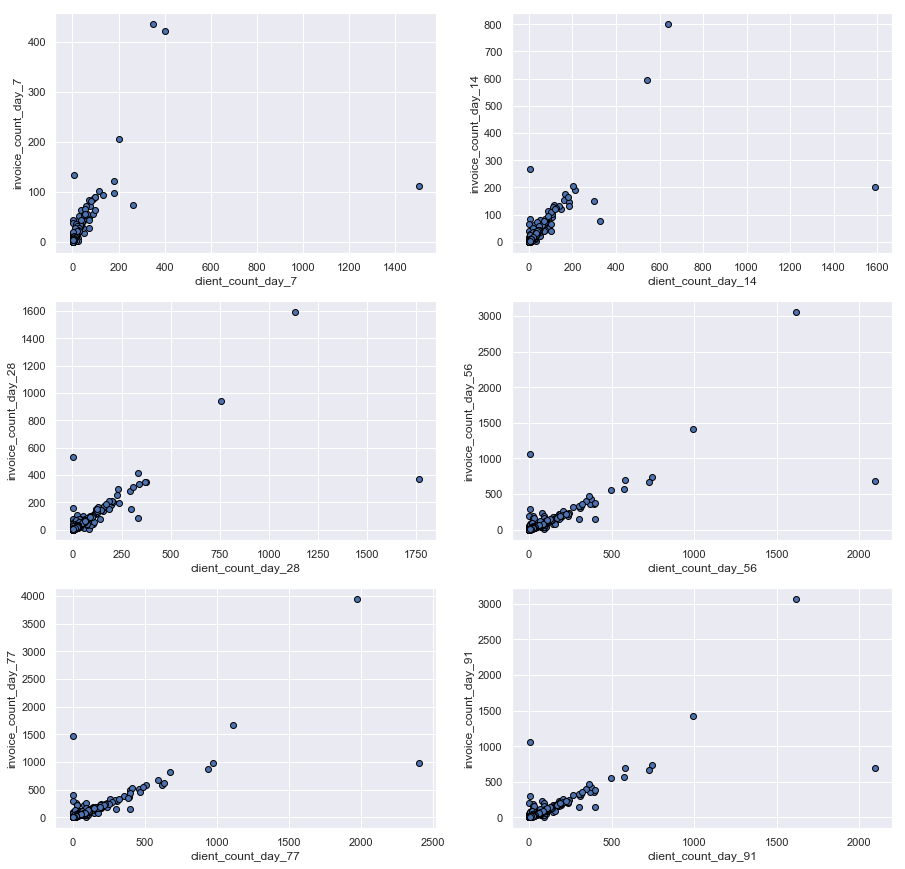

In [95]:
# Pair-to-pair cross-validation plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
# ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
ax7, ax14, ax28, ax56, ax77, ax91 = axes.flatten()

#------------------------------------------------------
x7 = df_periodic_invoice_fraud_counts['client_count_day_7']
y7 = df_periodic_invoice_fraud_counts['invoice_count_day_7']

ax7.scatter(x7, y7, edgecolors=(0, 0, 0))
ax7.set_xlabel('client_count_day_7')
ax7.set_ylabel('invoice_count_day_7')


#------------------------------------------------------
x14 = df_periodic_invoice_fraud_counts['client_count_day_14']
y14 = df_periodic_invoice_fraud_counts['invoice_count_day_14']

ax14.scatter(x14, y14, edgecolors=(0, 0, 0))
ax14.set_xlabel('client_count_day_14')
ax14.set_ylabel('invoice_count_day_14')


# ------------------------------------------------------
x28 = df_periodic_invoice_fraud_counts['client_count_day_28']
y28 = df_periodic_invoice_fraud_counts['invoice_count_day_28']

ax28.scatter(x28, y28, edgecolors=(0, 0, 0))
ax28.set_xlabel('client_count_day_28')
ax28.set_ylabel('invoice_count_day_28')

# ------------------------------------------------------
x56 = df_periodic_invoice_fraud_counts['client_count_day_56']
y56 = df_periodic_invoice_fraud_counts['invoice_count_day_56']

ax56.scatter(x56, y56, edgecolors=(0, 0, 0))
ax56.set_xlabel('client_count_day_56')
ax56.set_ylabel('invoice_count_day_56')

# ------------------------------------------------------
x77 = df_periodic_invoice_fraud_counts['client_count_day_77']
y77 = df_periodic_invoice_fraud_counts['invoice_count_day_77']

ax77.scatter(x77, y77, edgecolors=(0, 0, 0))
ax77.set_xlabel('client_count_day_77')
ax77.set_ylabel('invoice_count_day_77')

# ------------------------------------------------------
x91 = df_periodic_invoice_fraud_counts['client_count_day_91']
y91 = df_periodic_invoice_fraud_counts['invoice_count_day_91']

ax91.scatter(x56, y56, edgecolors=(0, 0, 0))
ax91.set_xlabel('client_count_day_91')
ax91.set_ylabel('invoice_count_day_91')

plt.show()


# 5. Separting Outliers
## 5.1 Determine and separating outliers

In [98]:
# Outliers cutoff
outliers_client_cutoff = 1000
outliers_invoice_cutoff = 1000

# No client and invoice outliers dataframe
df_periodic_invoice_no_client_outliers = df_periodic_invoice_fraud_counts[
                            df_periodic_invoice_fraud_counts['client_count_day_91'].astype(int) <= outliers_client_cutoff]

df_periodic_invoice_no_client_invoice_outliers = df_periodic_invoice_no_client_outliers[
                            df_periodic_invoice_no_client_outliers['invoice_count_day_91'].astype(int) <= outliers_invoice_cutoff]


In [99]:
df_periodic_invoice_no_client_invoice_outliers.shape

(397, 90)

In [100]:
# Outliers 
df_merge_all = df_periodic_invoice_fraud_counts.merge(df_periodic_invoice_no_client_invoice_outliers['systemid'],
                                                             on='systemid', how='left', indicator=True)

df_periodic_invoice_outliers = df_merge_all[df_merge_all["_merge"] == "left_only"].drop(columns=["_merge"])

In [101]:
df_periodic_invoice_outliers.shape

(6, 90)

### 5.2 Invoice vs. client plot: No outliers (after separating both outliers)

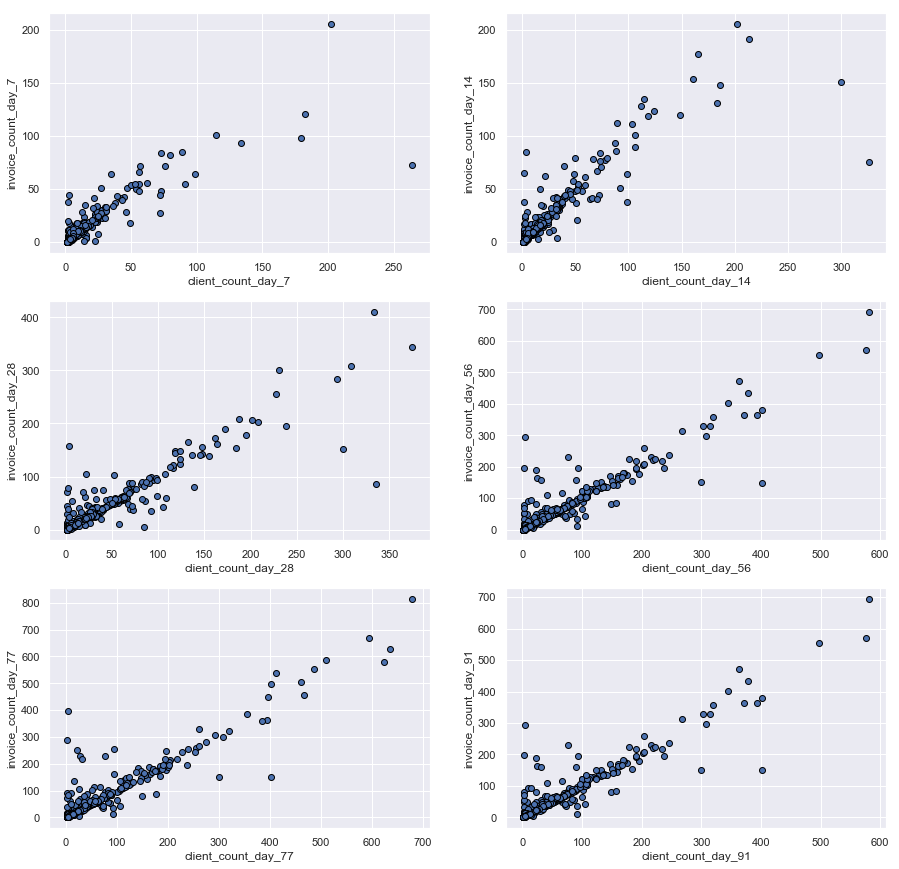

In [102]:
# Pair-to-pair cross-validation plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
# ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
ax7, ax14, ax28, ax56, ax77, ax91 = axes.flatten()

#------------------------------------------------------
x7 = df_periodic_invoice_no_client_invoice_outliers['client_count_day_7']
y7 = df_periodic_invoice_no_client_invoice_outliers['invoice_count_day_7']

ax7.scatter(x7, y7, edgecolors=(0, 0, 0))
ax7.set_xlabel('client_count_day_7')
ax7.set_ylabel('invoice_count_day_7')


#------------------------------------------------------
x14 = df_periodic_invoice_no_client_invoice_outliers['client_count_day_14']
y14 = df_periodic_invoice_no_client_invoice_outliers['invoice_count_day_14']

ax14.scatter(x14, y14, edgecolors=(0, 0, 0))
ax14.set_xlabel('client_count_day_14')
ax14.set_ylabel('invoice_count_day_14')


# ------------------------------------------------------
x28 = df_periodic_invoice_no_client_invoice_outliers['client_count_day_28']
y28 = df_periodic_invoice_no_client_invoice_outliers['invoice_count_day_28']

ax28.scatter(x28, y28, edgecolors=(0, 0, 0))
ax28.set_xlabel('client_count_day_28')
ax28.set_ylabel('invoice_count_day_28')

# ------------------------------------------------------
x56 = df_periodic_invoice_no_client_invoice_outliers['client_count_day_56']
y56 = df_periodic_invoice_no_client_invoice_outliers['invoice_count_day_56']

ax56.scatter(x56, y56, edgecolors=(0, 0, 0))
ax56.set_xlabel('client_count_day_56')
ax56.set_ylabel('invoice_count_day_56')

# ------------------------------------------------------
x77 = df_periodic_invoice_no_client_invoice_outliers['client_count_day_77']
y77 = df_periodic_invoice_no_client_invoice_outliers['invoice_count_day_77']

ax77.scatter(x77, y77, edgecolors=(0, 0, 0))
ax77.set_xlabel('client_count_day_77')
ax77.set_ylabel('invoice_count_day_77')

# ------------------------------------------------------
x91 = df_periodic_invoice_no_client_invoice_outliers['client_count_day_91']
y91 = df_periodic_invoice_no_client_invoice_outliers['invoice_count_day_91']

ax91.scatter(x56, y56, edgecolors=(0, 0, 0))
ax91.set_xlabel('client_count_day_91')
ax91.set_ylabel('invoice_count_day_91')

plt.show()

# 6. Analysis: Separating Periodic Features
## 6.1 Periodic client count distribution

In [103]:
df_periodic_client_counts_no_outliers = df_periodic_invoice_no_client_invoice_outliers[['systemid',
                                                         'client_count_day_7',
                                                         'client_count_day_14',
                                                         'client_count_day_21',
                                                         'client_count_day_28',
                                                         'client_count_day_35',
                                                         'client_count_day_42',
                                                         'client_count_day_49',
                                                         'client_count_day_56',
                                                         'client_count_day_63',
                                                         'client_count_day_70',
                                                         'client_count_day_77',
                                                         'client_count_day_84',
                                                         'client_count_day_91']]

In [104]:
df_periodic_client_counts_no_outliers.tail()

,systemid,client_count_day_7,client_count_day_14,client_count_day_21,client_count_day_28,client_count_day_35,client_count_day_42,client_count_day_49,client_count_day_56,client_count_day_63,client_count_day_70,client_count_day_77,client_count_day_84,client_count_day_91
398,4209018,3,3,3,3,3,3,3,3,3,3,3,3,3
399,4219188,1,1,1,1,1,1,1,1,1,1,1,1,1
400,4238602,5,10,12,22,23,23,23,23,23,23,23,23,23
401,4296696,5,10,13,13,13,13,13,13,13,13,13,13,13
402,4316674,4,4,4,4,4,4,4,4,4,4,4,4,4


## 6.2 Periodic invoce count distribution

In [105]:
df_periodic_invoice_counts_no_outliers = df_periodic_invoice_no_client_invoice_outliers[['systemid',
                                                         'invoice_count_day_7',
                                                         'invoice_count_day_14',
                                                         'invoice_count_day_21',
                                                         'invoice_count_day_28',
                                                         'invoice_count_day_35',
                                                         'invoice_count_day_42',
                                                         'invoice_count_day_49',
                                                         'invoice_count_day_56',
                                                         'invoice_count_day_63',
                                                         'invoice_count_day_70',
                                                         'invoice_count_day_77',
                                                         'invoice_count_day_84',
                                                         'invoice_count_day_91']]

In [106]:
df_periodic_invoice_counts_no_outliers.tail()

,systemid,invoice_count_day_7,invoice_count_day_14,invoice_count_day_21,invoice_count_day_28,invoice_count_day_35,invoice_count_day_42,invoice_count_day_49,invoice_count_day_56,invoice_count_day_63,invoice_count_day_70,invoice_count_day_77,invoice_count_day_84,invoice_count_day_91
398,4209018,2,2,2,2,2,2,2,2,2,2,2,2,2
399,4219188,0,0,0,0,0,0,0,0,0,0,0,0,0
400,4238602,4,9,11,21,23,23,23,23,23,23,23,23,23
401,4296696,4,9,12,12,12,12,12,12,12,12,12,12,12
402,4316674,3,3,3,3,3,3,3,3,3,3,3,3,3


## 6.3 Periodic Average Word Count in Invoice Description

In [107]:
df_periodic_invoice_avg_wc_description_no_outliers = df_periodic_invoice_no_client_invoice_outliers[['systemid',
                                                        'avg_wc_description_day_7',
                                                        'avg_wc_description_day_14',
                                                        'avg_wc_description_day_21',
                                                        'avg_wc_description_day_28',
                                                        'avg_wc_description_day_35',
                                                        'avg_wc_description_day_42',
                                                        'avg_wc_description_day_49',
                                                        'avg_wc_description_day_56',
                                                        'avg_wc_description_day_63',
                                                        'avg_wc_description_day_70',
                                                        'avg_wc_description_day_77',
                                                        'avg_wc_description_day_84',
                                                        'avg_wc_description_day_91']]

In [108]:
df_periodic_invoice_avg_wc_description_no_outliers.tail()

,systemid,avg_wc_description_day_7,avg_wc_description_day_14,avg_wc_description_day_21,avg_wc_description_day_28,avg_wc_description_day_35,avg_wc_description_day_42,avg_wc_description_day_49,avg_wc_description_day_56,avg_wc_description_day_63,avg_wc_description_day_70,avg_wc_description_day_77,avg_wc_description_day_84,avg_wc_description_day_91
398,4209018,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
399,4219188,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
400,4238602,5.5,6.111111,5.818182,5.818182,7.347826,7.347826,7.347826,7.347826,7.347826,7.347826,7.347826,7.347826,7.347826
401,4296696,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
402,4316674,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 6.4 Periodic Average Word Count in Invoice Notes

In [109]:
df_periodic_invoice_avg_wc_notes_no_outliers = df_periodic_invoice_no_client_invoice_outliers[['systemid',
                                                        'avg_wc_notes_day_7',
                                                        'avg_wc_notes_day_14',
                                                        'avg_wc_notes_day_21',
                                                        'avg_wc_notes_day_28',
                                                        'avg_wc_notes_day_35',
                                                        'avg_wc_notes_day_42',
                                                        'avg_wc_notes_day_49',
                                                        'avg_wc_notes_day_56',
                                                        'avg_wc_notes_day_63',
                                                        'avg_wc_notes_day_70',
                                                        'avg_wc_notes_day_77',
                                                        'avg_wc_notes_day_84',
                                                        'avg_wc_notes_day_91']]

In [110]:
df_periodic_invoice_avg_wc_notes_no_outliers.tail()

,systemid,avg_wc_notes_day_7,avg_wc_notes_day_14,avg_wc_notes_day_21,avg_wc_notes_day_28,avg_wc_notes_day_35,avg_wc_notes_day_42,avg_wc_notes_day_49,avg_wc_notes_day_56,avg_wc_notes_day_63,avg_wc_notes_day_70,avg_wc_notes_day_77,avg_wc_notes_day_84,avg_wc_notes_day_91
398,4209018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
399,4219188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
400,4238602,71.750000,67.777778,64.272727,64.272727,65.956522,65.956522,65.956522,65.956522,65.956522,65.956522,65.956522,65.956522,65.956522
401,4296696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
402,4316674,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667,9.666667


## 6.5 Periodic Average Word Count in Invoice Terms

In [111]:
df_periodic_invoice_avg_wc_terms_no_outliers = df_periodic_invoice_no_client_invoice_outliers[['systemid',
                                                        'avg_wc_terms_day_7',
                                                        'avg_wc_terms_day_14',
                                                        'avg_wc_terms_day_21',
                                                        'avg_wc_terms_day_28',
                                                        'avg_wc_terms_day_35',
                                                        'avg_wc_terms_day_42',
                                                        'avg_wc_terms_day_49',
                                                        'avg_wc_terms_day_56',
                                                        'avg_wc_terms_day_63',
                                                        'avg_wc_terms_day_70',
                                                        'avg_wc_terms_day_77',
                                                        'avg_wc_terms_day_84',
                                                        'avg_wc_terms_day_91']]

In [112]:
df_periodic_invoice_avg_wc_terms_no_outliers.tail()

,systemid,avg_wc_terms_day_7,avg_wc_terms_day_14,avg_wc_terms_day_21,avg_wc_terms_day_28,avg_wc_terms_day_35,avg_wc_terms_day_42,avg_wc_terms_day_49,avg_wc_terms_day_56,avg_wc_terms_day_63,avg_wc_terms_day_70,avg_wc_terms_day_77,avg_wc_terms_day_84,avg_wc_terms_day_91
398,4209018,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
399,4219188,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
400,4238602,43.5,44.0,44.0,44.0,44.434783,44.434783,44.434783,44.434783,44.434783,44.434783,44.434783,44.434783,44.434783
401,4296696,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
402,4316674,4.0,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


## 6.6 Periodic Average Word Count in Invoice Address

In [113]:
df_periodic_invoice_avg_wc_address_no_outliers = df_periodic_invoice_no_client_invoice_outliers[['systemid',
                                                        'avg_wc_address_day_7',
                                                        'avg_wc_address_day_14',
                                                        'avg_wc_address_day_21',
                                                        'avg_wc_address_day_28',
                                                        'avg_wc_address_day_35',
                                                        'avg_wc_address_day_42',
                                                        'avg_wc_address_day_49',
                                                        'avg_wc_address_day_56',
                                                        'avg_wc_address_day_63',
                                                        'avg_wc_address_day_70',
                                                        'avg_wc_address_day_77',
                                                        'avg_wc_address_day_84',
                                                        'avg_wc_address_day_91']]

In [114]:
df_periodic_invoice_avg_wc_address_no_outliers.tail()

,systemid,avg_wc_address_day_7,avg_wc_address_day_14,avg_wc_address_day_21,avg_wc_address_day_28,avg_wc_address_day_35,avg_wc_address_day_42,avg_wc_address_day_49,avg_wc_address_day_56,avg_wc_address_day_63,avg_wc_address_day_70,avg_wc_address_day_77,avg_wc_address_day_84,avg_wc_address_day_91
398,4209018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,4219188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400,4238602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401,4296696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,4316674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 7. Periodic Events for All Accounts
## 7.1 Importing periodic event data

In [116]:
# SQL for events 
sql_events = '''WITH selected_accounts_events AS (
    SELECT systemid,
           signup_date,
           signup_datetime
    FROM report_systems
    WHERE systemid IN (
        SELECT systemid FROM data_science.fraud_accounts_list
        ) AND is_freshbooks_account_active = '0' AND is_sales_managed ='0'
), events_activities AS (
    SELECT sae.systemid,
           signup_date,
           dd.date,
           datediff(days, signup_date, dd.date) as days_to_event,
           lower(e.event) as event,
           ec.count
    FROM selected_accounts_events AS sae
    LEFT JOIN event_counts AS ec USING (systemid)
    LEFT JOIN d_date AS dd USING (date_key)
    LEFT JOIN d_event e on ec.event_key = e.event_key
), event_groupings AS (
    SELECT distinct  ea.systemid,
                    ea.signup_date,
                    ea.date,
                    ea.event,
                    ea.count,
                    (CASE WHEN days_to_event BETWEEN 0 AND 7 THEN ea.count END) AS day_7_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 14 THEN ea.count END) AS day_14_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 21 THEN ea.count END) AS day_21_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 28 THEN ea.count END) AS day_28_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 35 THEN ea.count END) AS day_35_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 42 THEN ea.count END) AS day_42_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 49 THEN ea.count END) AS day_49_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 56 THEN ea.count END) AS day_56_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 63 THEN ea.count END) AS day_63_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 70 THEN ea.count END) AS day_70_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 77 THEN ea.count END) AS day_77_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 84 THEN ea.count END) AS day_84_event,
                    (CASE WHEN days_to_event BETWEEN 0 AND 91 THEN ea.count END) AS day_91_event
    FROM events_activities AS ea
)
SELECT systemid,
       signup_date,
       date,
       event,
       count,
       sum(day_7_event) AS event_count_day_7,
       sum(day_14_event) AS event_count_day_14,
       sum(day_21_event) AS event_count_day_21,
       sum(day_28_event) AS event_count_day_28,
       sum(day_35_event) AS event_count_day_35,
       sum(day_42_event) AS event_count_day_42,
       sum(day_49_event) AS event_count_day_49,
       sum(day_56_event) AS event_count_day_56,
       sum(day_63_event) AS event_count_day_63,
       sum(day_70_event) AS event_count_day_70,
       sum(day_77_event) AS event_count_day_77,
       sum(day_84_event) AS event_count_day_84,
       sum(day_91_event) AS event_count_day_91
From event_groupings
GROUP BY systemid, signup_date, date, event, count
ORDER BY systemid, count DESC;'''

# Import as dataframe from redshift
# df_events_fraud_accounts = pd.read_sql_query(sql_events, connect_to_db)
df_events_fraud_accounts = pig.run_query(sql_events, return_data=True)


In [117]:
df_events_fraud_accounts.head()

,systemid,signup_date,date,event,count,event_count_day_7,event_count_day_14,event_count_day_21,event_count_day_28,event_count_day_35,event_count_day_42,event_count_day_49,event_count_day_56,event_count_day_63,event_count_day_70,event_count_day_77,event_count_day_84,event_count_day_91
0,140971,2009-05-28,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,223260,2010-05-17,2015-04-23,pageview,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,223260,2010-05-17,2015-03-05,pageview,159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,223260,2010-05-17,2015-02-11,ajax request,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,223260,2010-05-17,2015-04-23,ajax request,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
df_events_fraud_accounts.shape

(532131, 18)

In [119]:
# Export as csv file
df_events_fraud_accounts.to_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/periodic_events_fraud_accounts.csv", 
                                      sep="\t", index=False)

## 7.2 Removing whitespace from the event string

In [121]:
df_events_fraud_accounts = df_events_fraud_accounts[~df_events_fraud_accounts.astype(str).eq('None').any(1)]

In [122]:
df_events_fraud_accounts.head()

,systemid,signup_date,date,event,count,event_count_day_7,event_count_day_14,event_count_day_21,event_count_day_28,event_count_day_35,event_count_day_42,event_count_day_49,event_count_day_56,event_count_day_63,event_count_day_70,event_count_day_77,event_count_day_84,event_count_day_91
1,223260,2010-05-17,2015-04-23,pageview,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,223260,2010-05-17,2015-03-05,pageview,159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,223260,2010-05-17,2015-02-11,ajax request,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,223260,2010-05-17,2015-04-23,ajax request,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,223260,2010-05-17,2015-02-11,pageview,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df_events_fraud_accounts.fillna(0, inplace=True)

In [124]:
df_events_fraud_accounts.head()

,systemid,signup_date,date,event,count,event_count_day_7,event_count_day_14,event_count_day_21,event_count_day_28,event_count_day_35,event_count_day_42,event_count_day_49,event_count_day_56,event_count_day_63,event_count_day_70,event_count_day_77,event_count_day_84,event_count_day_91
1,223260,2010-05-17,2015-04-23,pageview,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,223260,2010-05-17,2015-03-05,pageview,159.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,223260,2010-05-17,2015-02-11,ajax request,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,223260,2010-05-17,2015-04-23,ajax request,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,223260,2010-05-17,2015-02-11,pageview,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
df_events_fraud_accounts.shape

(532129, 18)

In [126]:
# Using lambda function to remove the white space in the event string name
df_events_fraud_accounts['event_name'] = df_events_fraud_accounts.apply(lambda x: x['event'].replace(' ', ''), axis=1)

In [127]:
df_events_fraud_accounts.head()

,systemid,signup_date,date,event,count,event_count_day_7,event_count_day_14,event_count_day_21,event_count_day_28,event_count_day_35,event_count_day_42,event_count_day_49,event_count_day_56,event_count_day_63,event_count_day_70,event_count_day_77,event_count_day_84,event_count_day_91,event_name
1,223260,2010-05-17,2015-04-23,pageview,166.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pageview
2,223260,2010-05-17,2015-03-05,pageview,159.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pageview
3,223260,2010-05-17,2015-02-11,ajax request,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ajaxrequest
4,223260,2010-05-17,2015-04-23,ajax request,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ajaxrequest
5,223260,2010-05-17,2015-02-11,pageview,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pageview


In [128]:
# Export as csv file
df_events_fraud_accounts.to_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/periodic_events_fraud_accounts.csv", 
                                      sep="\t", index=False)

# 8. Final Features Extraction: Day 7

In [166]:
# Renaming dataframe
df_periodic_invoice_all_counts = df_periodic_invoice_fraud_counts
df_events_all_accounts = df_events_fraud_accounts

In [171]:
# list(df_periodic_invoice_all_counts)

In [172]:
########################## Final Features Extraction: Day 7 ##############################

# Filtered the events columns for day 7 period
df_events_all_accounts_day_7 = df_events_all_accounts[['systemid', 'event_count_day_7', 'event_name']]

### Pivote the Day 7 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_7 = df_events_all_accounts_day_7.pivot_table(values='event_count_day_7', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_7.columns.name = None

# Reset the index
df_events_all_accounts_day_7 = df_events_all_accounts_day_7.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_7.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_7.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_7.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_7 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_7.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_7[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_7 = \
            df_events_all_accounts_day_7.loc[:, df_events_all_accounts_day_7.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 7
df_invoice_features_all_accounts_day_7 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_7',
        'avg_wc_notes_day_7',
        'avg_wc_terms_day_7',
        'avg_wc_address_day_7',
        'invoice_count_day_7',
        'client_count_day_7',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_7.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_7.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_7 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_7.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_7 = pd.merge(df_events_imp_features_all_accounts_day_7, 
                                   df_invoice_features_all_accounts_day_7,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_7.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_7.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_7 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_7.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [174]:
# list(df_final_features_day_7)

In [175]:
########################## Final Features Extraction: Day 14 ##############################

# Filtered the events columns for day 14 period
df_events_all_accounts_day_14 = df_events_all_accounts[['systemid', 'event_count_day_14', 'event_name']]

### Pivote the Day 14 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_14 = df_events_all_accounts_day_14.pivot_table(values='event_count_day_14', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_14.columns.name = None

# Reset the index
df_events_all_accounts_day_14 = df_events_all_accounts_day_14.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_14.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_14.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_14.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_14 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_14.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_14[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_14 = \
            df_events_all_accounts_day_14.loc[:, df_events_all_accounts_day_14.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 14
df_invoice_features_all_accounts_day_14 = df_periodic_invoice_all_counts[[
        'systemid',
    'is_freshbooks_account_active',
 'is_sales_managed',
        'avg_wc_description_day_14',
        'avg_wc_notes_day_14',
        'avg_wc_terms_day_14',
        'avg_wc_address_day_14',
        'invoice_count_day_14',
        'client_count_day_14',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_14.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_14.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_14 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_14.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_14 = pd.merge(df_events_imp_features_all_accounts_day_14, 
                                   df_invoice_features_all_accounts_day_14,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_14.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_14.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_14 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_14.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [176]:
########################## Final Features Extraction: Day 21 ##############################

# Filtered the events columns for day 21 period
df_events_all_accounts_day_21 = df_events_all_accounts[['systemid', 'event_count_day_21', 'event_name']]

### Pivote the Day 21 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_21 = df_events_all_accounts_day_21.pivot_table(values='event_count_day_21', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_21.columns.name = None

# Reset the index
df_events_all_accounts_day_21 = df_events_all_accounts_day_21.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_21.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_21.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_21.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_21 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_21.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_21[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_21 = \
            df_events_all_accounts_day_21.loc[:, df_events_all_accounts_day_21.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 21
df_invoice_features_all_accounts_day_21 = df_periodic_invoice_all_counts[[
        'systemid',
    'is_freshbooks_account_active',
 'is_sales_managed',
        'avg_wc_description_day_21',
        'avg_wc_notes_day_21',
        'avg_wc_terms_day_21',
        'avg_wc_address_day_21',
        'invoice_count_day_21',
        'client_count_day_21',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_21.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_21.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_21 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_21.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_21 = pd.merge(df_events_imp_features_all_accounts_day_21, 
                                   df_invoice_features_all_accounts_day_21,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_21.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_21.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_21 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_21.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [178]:
########################## Final Features Extraction: Day 28 ##############################

# Filtered the events columns for day 28 period
df_events_all_accounts_day_28 = df_events_all_accounts[['systemid', 'event_count_day_28', 'event_name']]

### Pivote the Day 28 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_28 = df_events_all_accounts_day_28.pivot_table(values='event_count_day_28', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_28.columns.name = None

# Reset the index
df_events_all_accounts_day_28 = df_events_all_accounts_day_28.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_28.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_28.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_28.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_28 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_28.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_28[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_28 = \
            df_events_all_accounts_day_28.loc[:, df_events_all_accounts_day_28.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 28
df_invoice_features_all_accounts_day_28 = df_periodic_invoice_all_counts[[
        'systemid',
    'is_freshbooks_account_active',
 'is_sales_managed',
        'avg_wc_description_day_28',
        'avg_wc_notes_day_28',
        'avg_wc_terms_day_28',
        'avg_wc_address_day_28',
        'invoice_count_day_28',
        'client_count_day_28',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_28.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_28.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_28 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_28.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_28 = pd.merge(df_events_imp_features_all_accounts_day_28, 
                                   df_invoice_features_all_accounts_day_28,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_28.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_28.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_28 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_28.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [179]:
########################## Final Features Extraction: Day 35 ##############################

# Filtered the events columns for day 35 period
df_events_all_accounts_day_35 = df_events_all_accounts[['systemid', 'event_count_day_35', 'event_name']]

### Pivote the Day 35 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_35 = df_events_all_accounts_day_35.pivot_table(values='event_count_day_35', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_35.columns.name = None

# Reset the index
df_events_all_accounts_day_35 = df_events_all_accounts_day_35.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_35.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_35.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_35.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_35 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_35.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_35[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_35 = \
            df_events_all_accounts_day_35.loc[:, df_events_all_accounts_day_35.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 35
df_invoice_features_all_accounts_day_35 = df_periodic_invoice_all_counts[[
        'systemid',
    'is_freshbooks_account_active',
 'is_sales_managed',
        'avg_wc_description_day_35',
        'avg_wc_notes_day_35',
        'avg_wc_terms_day_35',
        'avg_wc_address_day_35',
        'invoice_count_day_35',
        'client_count_day_35',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_35.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_35.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_35 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_35.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_35 = pd.merge(df_events_imp_features_all_accounts_day_35, 
                                   df_invoice_features_all_accounts_day_35,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_35.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_35.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_35 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_35.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [180]:
########################## Final Features Extraction: Day 42 ##############################

# Filtered the events columns for day 42 period
df_events_all_accounts_day_42 = df_events_all_accounts[['systemid', 'event_count_day_42', 'event_name']]

### Pivote the Day 42 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_42 = df_events_all_accounts_day_42.pivot_table(values='event_count_day_42', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_42.columns.name = None

# Reset the index
df_events_all_accounts_day_42 = df_events_all_accounts_day_42.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_42.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_42.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_42.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_42 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_42.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_42[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_42 = \
            df_events_all_accounts_day_42.loc[:, df_events_all_accounts_day_42.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 42
df_invoice_features_all_accounts_day_42 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_42',
        'avg_wc_notes_day_42',
        'avg_wc_terms_day_42',
        'avg_wc_address_day_42',
        'invoice_count_day_42',
        'client_count_day_42',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_42.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_42.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_42 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_42.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_42 = pd.merge(df_events_imp_features_all_accounts_day_42, 
                                   df_invoice_features_all_accounts_day_42,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_42.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_42.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_42 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_42.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [181]:
########################## Final Features Extraction: Day 49 ##############################

# Filtered the events columns for day 49 period
df_events_all_accounts_day_49 = df_events_all_accounts[['systemid', 'event_count_day_49', 'event_name']]

### Pivote the Day 49 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_49 = df_events_all_accounts_day_49.pivot_table(values='event_count_day_49', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_49.columns.name = None

# Reset the index
df_events_all_accounts_day_49 = df_events_all_accounts_day_49.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_49.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_49.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_49.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_49 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_49.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_49[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_49 = \
            df_events_all_accounts_day_49.loc[:, df_events_all_accounts_day_49.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 49
df_invoice_features_all_accounts_day_49 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_49',
        'avg_wc_notes_day_49',
        'avg_wc_terms_day_49',
        'avg_wc_address_day_49',
        'invoice_count_day_49',
        'client_count_day_49',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_49.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_49.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_49 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_49.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_49 = pd.merge(df_events_imp_features_all_accounts_day_49, 
                                   df_invoice_features_all_accounts_day_49,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_49.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_49.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_49 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_49.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [182]:
########################## Final Features Extraction: Day 56 ##############################

# Filtered the events columns for day 56 period
df_events_all_accounts_day_56 = df_events_all_accounts[['systemid', 'event_count_day_56', 'event_name']]

### Pivote the Day 56 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_56 = df_events_all_accounts_day_56.pivot_table(values='event_count_day_56', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_56.columns.name = None

# Reset the index
df_events_all_accounts_day_56 = df_events_all_accounts_day_56.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_56.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_56.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_56.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_56 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_56.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_56[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_56 = \
            df_events_all_accounts_day_56.loc[:, df_events_all_accounts_day_56.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 56
df_invoice_features_all_accounts_day_56 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_56',
        'avg_wc_notes_day_56',
        'avg_wc_terms_day_56',
        'avg_wc_address_day_56',
        'invoice_count_day_56',
        'client_count_day_56',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_56.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_56.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_56 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_56.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_56 = pd.merge(df_events_imp_features_all_accounts_day_56, 
                                   df_invoice_features_all_accounts_day_56,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_56.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_56.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_56 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_56.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [183]:
########################## Final Features Extraction: Day 63 ##############################

# Filtered the events columns for day 63 period
df_events_all_accounts_day_63 = df_events_all_accounts[['systemid', 'event_count_day_63', 'event_name']]

### Pivote the Day 63 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_63 = df_events_all_accounts_day_63.pivot_table(values='event_count_day_63', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_63.columns.name = None

# Reset the index
df_events_all_accounts_day_63 = df_events_all_accounts_day_63.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_63.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_63.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_63.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_63 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_63.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_63[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_63 = \
            df_events_all_accounts_day_63.loc[:, df_events_all_accounts_day_63.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 63
df_invoice_features_all_accounts_day_63 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_63',
        'avg_wc_notes_day_63',
        'avg_wc_terms_day_63',
        'avg_wc_address_day_63',
        'invoice_count_day_63',
        'client_count_day_63',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_63.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_63.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_63 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_63.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_63 = pd.merge(df_events_imp_features_all_accounts_day_63, 
                                   df_invoice_features_all_accounts_day_63,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_63.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_63.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_63 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_63.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [ ]:
########################## Final Features Extraction: Day 70 ##############################

# Filtered the events columns for day 70 period
df_events_all_accounts_day_70 = df_events_all_accounts[['systemid', 'event_count_day_70', 'event_name']]

### Pivote the Day 70 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_70 = df_events_all_accounts_day_70.pivot_table(values='event_count_day_70', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_70.columns.name = None

# Reset the index
df_events_all_accounts_day_70 = df_events_all_accounts_day_70.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_70.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_70.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_70.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_70 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_70.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_70[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_70 = \
            df_events_all_accounts_day_70.loc[:, df_events_all_accounts_day_70.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 70
df_invoice_features_all_accounts_day_70 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_70',
        'avg_wc_notes_day_70',
        'avg_wc_terms_day_70',
        'avg_wc_address_day_70',
        'invoice_count_day_70',
        'client_count_day_70',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_70.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_70.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_70 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_70.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_70 = pd.merge(df_events_imp_features_all_accounts_day_70, 
                                   df_invoice_features_all_accounts_day_70,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_70.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_70.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_70 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_70.tsv", sep="\t")


In [184]:
########################## Final Features Extraction: Day 77 ##############################

# Filtered the events columns for day 77 period
df_events_all_accounts_day_77 = df_events_all_accounts[['systemid', 'event_count_day_77', 'event_name']]

### Pivote the Day 77 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_77 = df_events_all_accounts_day_77.pivot_table(values='event_count_day_77', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_77.columns.name = None

# Reset the index
df_events_all_accounts_day_77 = df_events_all_accounts_day_77.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_77.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_77.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_77.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_77 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_77.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_77[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_77 = \
            df_events_all_accounts_day_77.loc[:, df_events_all_accounts_day_77.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 77
df_invoice_features_all_accounts_day_77 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_77',
        'avg_wc_notes_day_77',
        'avg_wc_terms_day_77',
        'avg_wc_address_day_77',
        'invoice_count_day_77',
        'client_count_day_77',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_77.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_77.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_77 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_77.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_77 = pd.merge(df_events_imp_features_all_accounts_day_77, 
                                   df_invoice_features_all_accounts_day_77,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_77.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_77.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_77 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_77.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [185]:
########################## Final Features Extraction: Day 84 ##############################

# Filtered the events columns for day 84 period
df_events_all_accounts_day_84 = df_events_all_accounts[['systemid', 'event_count_day_84', 'event_name']]

### Pivote the Day 84 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_84 = df_events_all_accounts_day_84.pivot_table(values='event_count_day_84', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_84.columns.name = None

# Reset the index
df_events_all_accounts_day_84 = df_events_all_accounts_day_84.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_84.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_84.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_84.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_84 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_84.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_84[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_84 = \
            df_events_all_accounts_day_84.loc[:, df_events_all_accounts_day_84.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 84
df_invoice_features_all_accounts_day_84 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_84',
        'avg_wc_notes_day_84',
        'avg_wc_terms_day_84',
        'avg_wc_address_day_84',
        'invoice_count_day_84',
        'client_count_day_84',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_84.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_84.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_84 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_84.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_84 = pd.merge(df_events_imp_features_all_accounts_day_84, 
                                   df_invoice_features_all_accounts_day_84,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_84.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_84.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_84 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_84.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [186]:
########################## Final Features Extraction: Day 91 ##############################

# Filtered the events columns for day 91 period
df_events_all_accounts_day_91 = df_events_all_accounts[['systemid', 'event_count_day_91', 'event_name']]

### Pivote the Day 91 Events (Each Unique Event Become a Column)###
# Pivot table based on the unique column value in 'event_name'
df_events_all_accounts_day_91 = df_events_all_accounts_day_91.pivot_table(values='event_count_day_91', columns='event_name', index='systemid', aggfunc=np.sum,  fill_value=0)

# Drop the old column name
df_events_all_accounts_day_91.columns.name = None

# Reset the index
df_events_all_accounts_day_91 = df_events_all_accounts_day_91.reset_index()

# Replace 'NaN' with zero
df_events_all_accounts_day_91.fillna(0, inplace=True)

# CSV export 
df_events_all_accounts_day_91.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts_day_91.tsv", sep="\t", index=False)

# Import CSV
# df_events_all_accounts_day_91 = pd.read_csv(
#   "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/events_fraud_accounts.tsv", sep="\t")

# Importing importing features list
important_features = pd.read_csv( 
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/important_features.csv", sep="\n,")

# Get the important feature as a list
imp_features_list = list(important_features['important_feature'])

# Adding missing important feature column 
for i in range(len(imp_features_list)):
    if imp_features_list[i] in df_events_all_accounts_day_91.columns:
        #print("True") 
        continue
    else:
        #print("False")
        df_events_all_accounts_day_91[imp_features_list[i]] = 0


# Filtering only important features 
df_events_imp_features_all_accounts_day_91 = \
            df_events_all_accounts_day_91.loc[:, df_events_all_accounts_day_91.columns.str.contains('|'.join(imp_features_list))]


### Filtering average word counts features from the invoice data
# Invoice features at day 91
df_invoice_features_all_accounts_day_91 = df_periodic_invoice_all_counts[[
        'systemid',
        'is_freshbooks_account_active',
         'is_sales_managed',
        'avg_wc_description_day_91',
        'avg_wc_notes_day_91',
        'avg_wc_terms_day_91',
        'avg_wc_address_day_91',
        'invoice_count_day_91',
        'client_count_day_91',
        'is_freshbooks_account_active',
        'is_paying',
        'base_subscription_amount_first_upgrade',
        'upgrade_ever'
        ]]

# CSV export
df_invoice_features_all_accounts_day_91.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_91.tsv", sep="\t", index=False)

# Import CSV
# df_invoice_features_all_accounts_day_91 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_v1/invoice_features_fraud_accounts_day_91.tsv", sep="\t")

# Merging events' and invoice features
df_final_features_day_91 = pd.merge(df_events_imp_features_all_accounts_day_91, 
                                   df_invoice_features_all_accounts_day_91,
                                     on='systemid', how='left')

# CSV export 
df_final_features_day_91.to_csv(
    "/Users/dwahid/Documents/GitHub/fraud_detection/data_fraud/final_features_fraud_accounts_day_91.tsv", sep="\t", index=False)

# Import CSV
# df_final_features_day_91 = pd.read_csv(
#     "/Users/dwahid/Documents/GitHub/fraud_detection/data_final/final_features_fraud_accounts_day_91.tsv", sep="\t")


/Users/dwahid/Documents/GitHub/fraud_detection/venv_fraud/lib/python2.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
